In [1]:
import numpy as np
from hmmlearn import hmm
files = ["NR_004391.coverage","NR_002715.coverage","NR_027260.coverage","NR_001445.coverage",
         "NR_146119_3.coverage", "NM_003380.coverage"]
#coverage emissions are discrete (coverage values are always integers), thus using a multinomial
#model = hmm.GaussianHMM(n_components=2, covariance_type='spherical') #a discrete emission HMM with 2 states (hi and lo)
model = hmm.MultinomialHMM(n_components=2) #If i use multinomial I have to convert coverage values to 0 and 1
model.startprob_ = np.array([0.5, 0.5])
model.transmat_ = np.array([[0.994897959,0.005102041],
                            [0.005102041,0.994897959]])
model.emissionprob_ = np.array([[0.99, 0.01],
                                [0.01, 0.99]])

out = open("states.txt",'w')
covLengths = np.array([],dtype="int")
allCov = np.array([], dtype="int")
trimBy = 20
for file in files:
    covFile = open(file,'r')
    covLines = covFile.read().splitlines()

    num_samples = len(covLines[0].split())
    cov = np.zeros((len(covLines),num_samples), dtype="int")

    #First making a matrix of coverages, each replicate (bg or rx) is in one column
    #each row is one position in the RNA sequence

    for i in range(len(covLines)):
        thisline = covLines[i].split()
        numbers = []
        for j in thisline:
            value = int(float(j))
            numbers.append(value)
        cov[i] = numbers
    
    #flattening 2d coverage matrices into 1d vector
    #ex: [[1,2,3,4],[5,6,7,8]] -> [1,5,2,6,3,7,4,8]
    #but storing the lengths of each replicate so hmmlearn recognizes them as separate sequences
    allCov = np.concatenate((allCov,cov.flatten('F')))
    covLength = np.array([len(covLines)]*num_samples)
    covLengths = np.concatenate((covLengths,covLength))
    covFile.close()
    
allCovBin = np.copy(allCov) #converting values to 0 or 1 for Multinomial HMM
allCovBin[allCovBin<50] = 0
allCovBin[allCovBin>=50] = 1
cov1d = allCovBin.reshape(-1,1) #array needs to be in this shape for hmmlearn

print(len(cov1d))
print(cov1d[0:10])


20404
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


In [9]:
model.fit(cov1d, covLengths)
states = model.predict(cov1d, lengths=covLengths)

In [19]:
for i in states:
    out.write(str(i)+"\n")
out.close()

In [7]:
from sklearn.externals import joblib
#joblib.dump(model, "coverageHMM.pkl")

model = joblib.load("coverageHMM.pkl") #to load the trained model and use it on new data

In [8]:
#print(model.means_) #gaussianHMM has means for each state
print(model.startprob_)
print(model.emissionprob_)
print(model.transmat_)
#print(model.covars_) #gaussianHMM has means for each state

[0.21483785 0.78516215]
[[0.18654102 0.81345898]
 [0.62726052 0.37273948]]
[[0.67642436 0.32357564]
 [0.31936865 0.68063135]]


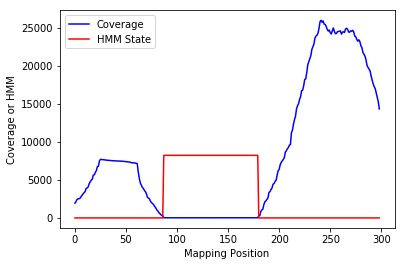

In [11]:
#now plot the predicted states on top of the coverages for each of the samples
%matplotlib inline
import matplotlib.pyplot as plt
cumCovLengths = [0]
sum = 0
states = np.array(states)
for length in covLengths:
    cumCovLengths.append(length+sum)
    sum+=length
#print(cumCovLengths)
for i in range(5,6): #len(covLengths)):
    x=np.arange(0,covLengths[i])
    aveCov = np.mean(allCov[cumCovLengths[i]:cumCovLengths[i+1]])
    plt.plot(x, allCov[cumCovLengths[i]:cumCovLengths[i+1]],'b-', label="Coverage")
    plt.plot(x, states[cumCovLengths[i]:cumCovLengths[i+1]]*aveCov,'r-', label="HMM State")
    plt.legend(loc='best')
    plt.ylabel('Coverage or HMM')
    plt.xlabel('Mapping Position')
    #plt.savefig('HMMplot'+str(i)+'.png')
    #plt.clf()